# Basic simulation study of periodogram-based frequency estimation

Prepared by Tom Loredo for the AAS237 time series workshop, 2021-01-08.

Some familiar imports, and importing the `SinusoidTimeSeriesSimulator` from the `stss` companion module. This class takes a set of parameters defining a true sinuoidal signal, and an observation plan, and enables simulating observations, computing periodograms, and computing quantities related to Bayesian estimation of a periodic signal's frequency.

In [1]:
import itertools

from pylab import *
from numpy import *
from scipy.stats import norm
from scipy.fft import rfft, rfftfreq

from stss import SinusoidTimeSeriesSimulator

Prepare the notebook for plotting.

In [2]:
rc('figure.subplot', bottom=.125, top=.95, right=.95)  # left=0.125
# rc('lines', linewidth=2.0) # doesn't affect frame lines
rc('font', size=14)  # default for labels (not axis labels)
rc('font', family='serif')  # default for labels (not axis labels)
rc('axes', labelsize=18)
rc('xtick.major', pad=8)
rc('xtick', labelsize=14)
rc('ytick.major', pad=8)
rc('ytick', labelsize=14)
rc('savefig', dpi=300)
rc('axes.formatter', limits=(-4,4))

ion()

blue = {'color':'blue', 'mec':'blue', 'mfc':'blue'}
green = {'color':'g', 'mec':'g', 'mfc':'g'}

# Color cycler for plots with multiple simulations:
ccyc = itertools.cycle(['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9'])

## Instantiate the simulator

Instantiate the time series simulator for 50 samples with unit spacing of a signal with period 3.5 (arbitrary units). **Play with the signal-to-noise level,** either by changing the amplitude, `A`, or the noise standard deviation, `sig`.

At high S/N, the periodogram will have a large peak, and as a result the posterior PDF for the frequency will have a very *narrow* peak. If you simulate many high S/N time series, you should find the true frequency to be covered by the peak pretty much all of the time.

At modest S/N, the periodogram will have strong sidelobes.  The true frequency won't always lie in the main peak. You should find that when it's missed by the main peak, it tends to fall in a smaller peak. This signals that the peaks are *meaningful*; they communicate something about period uncertainty that would be lost if the peaks were treated as "leakage" and smoothed away by tapering or some similar operation.

In [3]:
tss = SinusoidTimeSeriesSimulator(dt=1., n=50, tau=3.5, A=.9, phi=.5, sig=1.)
print('True sinusoid params (A,nu,w,phi):', tss.A, tss.nu, tss.w, tss.phi)

True sinusoid params (A,nu,w,phi): 0.9 0.2857142857142857 1.7951958020513104 0.5


## Plot a simulated time series

This cell simply plots one simulated dataset (along with the true signal as a dashed gray curve).

Text(0, 0.5, 'Sample value')

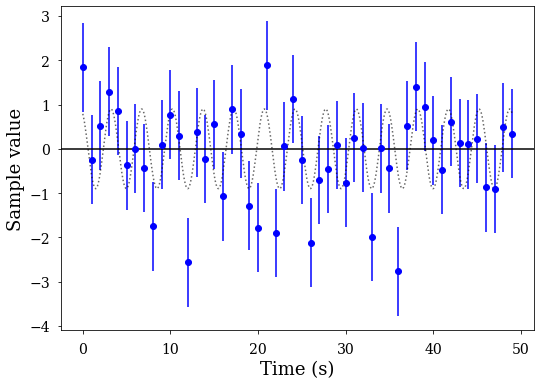

In [4]:
# Plot a simulated time series.

rc('figure.subplot', top=.95, right=.96, bottom=.2, left=.14, hspace=.1)
figure(figsize=(8,6))
tss.simulate()
# plot(tss.times, tss.y, 'o', **blue)
errorbar(tss.times, tss.y, yerr=tss.sig, fmt='o', **blue)
times, tsignal = tss.tsignal(10*tss.n)
plot(times, tsignal, 'k:', alpha=.6)
# ylim(-2.75, 2.75)
axhline(0., c='k')
xlabel('Time (s)')
ylabel('Sample value')

## Plot a single periodogram, computed two ways

This plot compares direct (but slow) computation of the periodogram with DFT-based computation.

The direct algorithm uses the following code, which should be largely self-explanatory. It will work for any array of input frequencies, `freq`.
```python
for i, f in enumerate(freqs):
    wt = twopi*f*self.times
    C = sum(self.y * cos(wt))
    S = sum(self.y * sin(wt))
    pg[i] = (C**2 + S**2)/self.n
```

The DFT-based algorithm computes the periodogram only at the Fourier frequencies, unless provided an oversampling parameter, `over`.  If `over=4`, for example, it evaluates the periodogram at 4x the number of Fourier frequencies, by zero-padding the data before transforming.  Here's the code:
```python
if over == 1:
    y = self.y
else:
    nz = over*self.n
    y = pad(self.y, ((0, nz)))
dft = rfft(y)
freqs = rfftfreq(y.shape[0], d=self.dt)
```

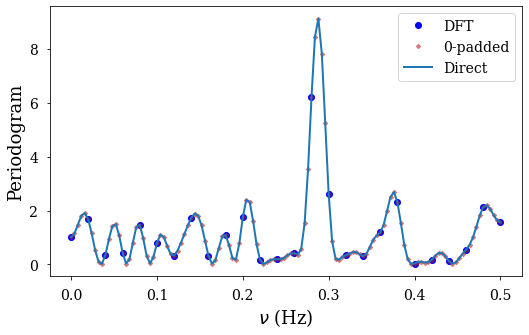

In [5]:
# Compute the periodogram with a slow, direct algorithm, and via a zero-padded DFT.

figure(figsize=(8,5))
xlabel(r'$\nu$ (Hz)')
ylabel(r'Periodogram')

freqs, pgram = tss.pgram_fft()
plot(freqs, pgram, 'ob', ms=6, label='DFT')
# spgram = tss.pgram(freqs)
# plot(freqs, spgram, '-', c='C1', lw=2)

# 0-pad to oversample:
freqs, pgram = tss.pgram_fft(4)
plot(freqs, pgram, 'D', c='firebrick', ms=4, mew=0, alpha=.6, label='0-padded')
spgram = tss.pgram(freqs)
plot(freqs, spgram, '-', c='C0', lw=2, label='Direct')
legend()

## Compute periodograms for many simulated datasets

For a basic simulation study, we first define a helper function for computing and plotting periodograms, and checking calibration (how often a probabilistic prediction is correct).

In [6]:
def pgram_case(tss, ax_lml=None, ax_mpp=None, c='k', over=20,
               lml_mode=True, ffreq=False, lw=1, **kwds):
    """
    Helper function for handling a single case in periodogram calculations
    for multiple simulated time series.

    This helper can plot the log marginal likelihood and the normalized
    posterior for the signal frequency.

    It can also compute how large an HPD region has to be to include the
    true frequency.
    """
    freqs, pgram, lml, mpp, mpp_t = tss.pgram_lml(over)

    # If the mode is more than a few sigma away from true freq, highlight
    # the curve.
    i = lml.argmax()
    lml_max = lml.max()
    lml_t = tss.pgram(tss.nu)/tss.sig
    if lml_max - lml_t > 2:
        lw = 2.5*lw

    if ax_lml:
        ax_lml.plot(freqs, lml, '-', c=c, lw=lw, **kwds)
        if lml_mode:
            ax_lml.plot([freqs[i]], [lml_max], 'D', c='firebrick', ms=4)
    if ax_mpp:
        ax_mpp.plot(freqs, mpp, '-', c=c, lw=lw, **kwds)
        # Symbol at p(true freq):
        ax_mpp.plot([tss.nu], [mpp_t], 'D', c='b', ms=4)

    # vlines at Fourier freqs:
    # ax_lml.vlines(tss.ffreqs, ylo, yhi, color='0.3', linestyle=':')

    # Plot points showing ordinates at Fourier frequencies.
    if ffreq and ax_lml:
        ffreqs, ordinates, lml, x, xx = tss.pgram_lml()
        # ??? divide by var?
        ax_lml.plot(ffreqs, lml, 'o', ms=6, mfc='k', mew=0)

    # Compute probability inside an HPD region containing the true freq.
    mpp_in = mpp[mpp > mpp_t]
    p_in = mpp_in.sum()/mpp.sum()
    return p_in

## Simulating many periodograms

Here we simulate a modest number of periodograms, to visually study how features of the periodogram relate to the true frequency.

The upper plot shows the log marginal likelihood functions for frequency, which are just proportional to the periodograms. The vertical line shows the true frequency, and the red diamonds show the locations of the periodogram peaks.

The lower plot converts the periodogram to a posterior PDF for frequency (using a uniform prior). The blue diamonds show the posterior density for the true frequency.

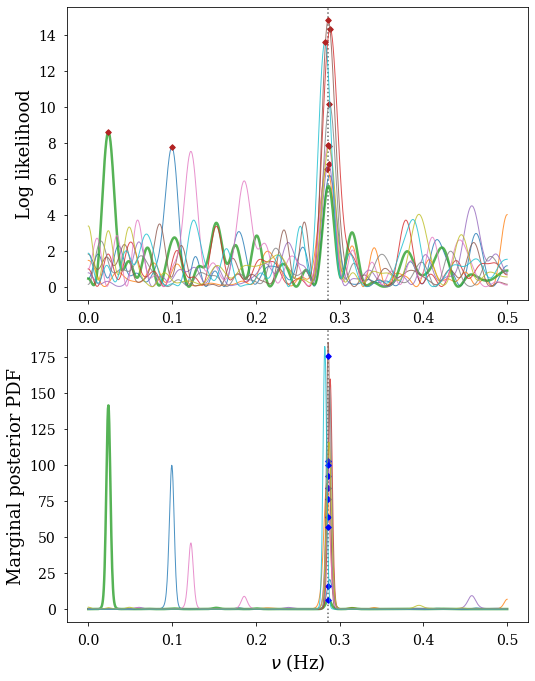

In [7]:
# Use the `pgram_case` helper to plot periodograms for multiple simulated datasets.

rc('figure.subplot', left=.15, right=.95, bottom=.12, top=.975)
figure(figsize=(8,10))

ax_lml = subplot(211)
ax_lml.set_xlabel(r'$\nu$ (Hz)')
ax_lml.set_ylabel(r'Log likelihood')
ax_lml.axvline(tss.nu, c='k', ls=':', alpha=.6)

ax_mpp = subplot(212)
ax_mpp.set_xlabel(r'$\nu$ (Hz)')
ax_mpp.set_ylabel(r'Marginal posterior PDF')
ax_mpp.axvline(tss.nu, c='k', ls=':', alpha=.6)

# sim_pgram_plot(tss, ffreq=True, c='b', lw=2)

for i in range(10):
    tss.simulate()
    c = next(ccyc)
    pgram_case(tss, ax_lml, ax_mpp, c=c, lw=1., alpha=.8)

## Perform an HPD interval calibration test

Here we perform thousands of simulations, to see how often HPD regions cover the true value.

Bayesian methods are always *perfectly calibrated with respect to the prior*:
* Draw "true" parameter values from the prior.
* Simulate data.
* Compute the (marginal) posterior PDF for frequency, and an HPD region with probability $P$ (95%, say).
* Check to see if the true frequency is in the HPD region.
* Repeat and compute the fraction of the time the true frequency was covered, $C$
"Perfect calibration" means that, up to Monte Carlo uncertainties, if the calculation was done correctly, $C=P$.

Here we do a somewhat simpler coverage calculation:  We keep the parameters fixed, and see how often HPD regions of various sizes cover the true frequency. This parameter-dependent coverage, $C(\theta)$, may not equal the HPD region probability, $P$.  But:
* Were we to do this for many values of $\theta$, and average $C(\theta)$ weighted by the prior, we'll find $\langle C\rangle=P$.
* If the problem doesn't have strongly $\theta$-dependent coverage, then we expect $C\approx P$.

It's the latter point we're expecting to hold here (since there is nothing in the problem that should make performance depend on frequency, except perhaps if the frequency is near 0 or the Nyquist frequency.

This particular implementation is slightly clever:  It doesn't just check performance for one particular choice of $P$, but for all possible choices.  It does this by setting $P$ for each simulation to the value that creates an HPD region that just includes the true frequency on its boundary. Thus each run produces a different $P$.  You should be able to convince yourself that if everything is behaving correctly, the values of $P$ should follow a uniform distribution (try to come up with a word-based argument for why this should be true).

In general, this kind of calibration test is expensive, involving many simulations, and for each one, computation of the posterior and an HPD region.  It's not too bad for this simple problem, but for complex problems the computational cost may be prohibitive. But when you can do a calibration test, it's a pretty strong test of all aspects of your calculation: computing the likelihood, simulating data, and correctly summarizing the posterior.

In this case, the test led me to discover that I had to oversample in frequency quite a bit at high S/N—the posterior is so narrow in such cases, we need lots of points in order to get accurate probability integrals; but with enough points, the coverage is accurate. At low S/N, the performance isn't quite spot-on, most likely because of edge effects (i.e., we really should average WRT the prior, since performance will differ near 0 frequency and the Nyquist frequency, and Bayesian methods only guarantee *prior-averaged* performance). And of course, some integrals are being computed numerically and won't be 100% accurate.

Case 50...
Case 100...
Case 150...
Case 200...
Case 250...
Case 300...
Case 350...
Case 400...
Case 450...
Case 500...
Case 550...
Case 600...
Case 650...
Case 700...
Case 750...
Case 800...
Case 850...
Case 900...
Case 950...
Case 1000...
Chi^2 = 19.7


(0.0, 0.15)

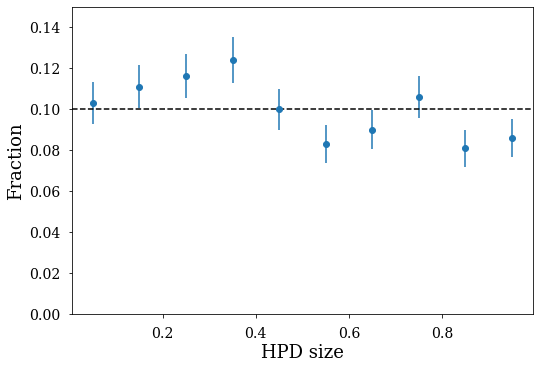

In [8]:
# Perform an HPD interval calibration test.

p_in = empty(1000)
for i in range(len(p_in)):
    if (i+1) % 50 == 0:
        print('Case {}...'.format(i+1))
    tss.simulate()
    # Oversampling must be large when S/N is high (narrow peaks).
    p_in[i] = pgram_case(tss, over=50)

# Estimated fractions from flat-prior beta-binomial mean, std:
nb = 10
h, edges = histogram(p_in, nb, (0., 1.))
frac = h/len(p_in)
f_err = sqrt(h)/len(p_in)
# frac = (h+1)/(len(p_in)+2)
# f_err = sqrt(frac*(1-frac)/(len(p_in)+3))
centers = 0.5*(edges[:-1] + edges[1:])
chi2 = sum(((frac-1./nb)/f_err)**2)
print('Chi^2 = {:.1f}'.format(chi2))

figure(figsize=(8,5))
xlabel('HPD size')
ylabel('Fraction')
errorbar(centers, frac, f_err, fmt='o')
axhline(1./nb, ls='--', c='k')
ylim(0., .15)